In [1]:
import os, sys
import numpy as np
import corner

sys.path.append('../')
import py21cmfish as p21fish

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mathtext as mathtext
import matplotlib.lines as mlines

%matplotlib inline

plt.style.use(['default','seaborn','seaborn-ticks'])
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['figure.figsize'] = (4,3)
mpl.rcParams['figure.dpi'] = 150

if os.path.exists(os.environ['WORK_DIR']+'/code/matplotlibrc'):
    from matplotlib import rc_file
    rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

    mathtext.FontConstantsBase.sup1 = 0.5
    mathtext.FontConstantsBase.sub1 = 0.2
    mathtext.FontConstantsBase.sub2 = 0.2

In [97]:
# Color palette
from palettable.tableau import Tableau_20, ColorBlind_10
from palettable.cubehelix import cubehelix3_16

colorblind = False

if colorblind:
    cols = ColorBlind_10.hex_colors

    col_pess  = cols[6]
    col_mod   = cols[4]
    col_alpha = cols[5]
    col_mcmc  = cols[3]
    col_P19   = 'tab:orange'

else:
    cols = cubehelix3_16.hex_colors

    col_pess  = '0.4'
    col_mod   = cols[10]
    col_alpha = cols[3]
    col_mcmc  = '0.3'
    col_P19   = cols[-5]

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 21cmfish examples

This notebook loads and plots example posteriors based on the 21cm power spectrum.

To run the notebook you must first unpack the data directories in `/examples/`

1. [EOS21 - CDM fiducial with pop II and pop III galaxies](#EOS21)
2. [Comparison with Park+19](#Comparison-to-Park+19)
3. [Adding your own new parameter](#Adding-a-new-parameter)

In [54]:
examples_dir = p21fish.base_path+'examples/'
data_dir     = examples_dir+'data/'
noise_dir    = data_dir+'21cmSense_noise/'

# EOS21

This is a fiducial case from [Munoz+2021](#) with CDM, and with both pop II and pop III galaxies.

In [55]:
# Find the parameters we varied and fiducials from the config file
# but you could also list these yourself (especially if you want to change the order)
astro_params_vary, astro_params_fid = p21fish.get_params_fid(
                                        config_file=p21fish.base_path+'21cmFAST_config_files/EoS_mini.config')

print('Varying parameters:',astro_params_vary)
print('Fiducial parameter values:',astro_params_fid)

assert type(astro_params_vary) == list, 'astro_params_vary must be a list'
assert type(astro_params_fid) == dict, 'astro_params_vary must be a dict'

Varying parameters: ['ALPHA_STAR', 'F_STAR10', 'ALPHA_ESC', 'F_ESC10', 'ALPHA_STAR_MINI', 'F_STAR7_MINI', 'F_ESC7_MINI', 'L_X', 'NU_X_THRESH', 'A_LW']
Fiducial parameter values: {'ALPHA_ESC': -0.3, 'F_ESC10': -1.35, 'ALPHA_STAR': 0.5, 'F_STAR10': -1.25, 't_STAR': 0.5, 'F_STAR7_MINI': -2.5, 'ALPHA_STAR_MINI': 0.0, 'F_ESC7_MINI': -1.35, 'L_X': 40.5, 'L_X_MINI': 40.5, 'NU_X_THRESH': 500.0, 'A_VCB': 1.0, 'A_LW': 2.0}


## Load parameters

### Moderate noise

In [56]:
# Load each parameter into a dictionary
params_EoS = {}
astro_params_vary_EoS = ['F_STAR10', 'ALPHA_STAR', 'F_ESC10', 'ALPHA_ESC', 
                         'F_STAR7_MINI', 'ALPHA_STAR_MINI', 'F_ESC7_MINI', 'L_X', 'NU_X_THRESH', 'A_LW']

for param in astro_params_vary_EoS:
    params_EoS[param] = p21fish.Parameter(param=param, 
                                          output_dir=data_dir+'EOS21/', 
                                          PS_err_dir=noise_dir+'21cmSense_fid_EOS21/',
                                          clobber=False, Park19=None,
                                          vb=False)

########### fisher set up for F_STAR10
########### fisher set up for ALPHA_STAR
########### fisher set up for F_ESC10
########### fisher set up for ALPHA_ESC
########### fisher set up for F_STAR7_MINI
########### fisher set up for ALPHA_STAR_MINI
########### fisher set up for F_ESC7_MINI
########### fisher set up for L_X
########### fisher set up for NU_X_THRESH
########### fisher set up for A_LW


### Pessimistic noise

In [57]:
# Load each parameter into a dictionary
params_EoS_pess = {}

for param in astro_params_vary_EoS:
    params_EoS_pess[param] = p21fish.Parameter(param=param, 
                                          output_dir=data_dir+'EOS21/', 
                                          PS_err_dir=noise_dir+'21cmSense_pess_EOS21/',
                                          clobber=False, Park19=None,
                                          vb=False)

########### fisher set up for F_STAR10
########### fisher set up for ALPHA_STAR
########### fisher set up for F_ESC10
########### fisher set up for ALPHA_ESC
########### fisher set up for F_STAR7_MINI
########### fisher set up for ALPHA_STAR_MINI
########### fisher set up for F_ESC7_MINI
########### fisher set up for L_X
########### fisher set up for NU_X_THRESH
########### fisher set up for A_LW


## Fisher matrix analysis

`make_fisher_matrix()` creates the Fisher matrix and its inverse from a Parameters dictionary. The resulting ellipses can be plotted with `plot_triangle()`.

In [58]:
Fij_matrix_PS, Finv_PS = p21fish.make_fisher_matrix(params_EoS, fisher_params=astro_params_vary_EoS, 
                                                     hpeak=0.0, obs='PS',
                                                     k_min=0.1, k_max=1, 
                                                     z_min=5.7, z_max=30., 
                                                     sigma_mod_frac=0.2,
                                                     add_sigma_poisson=True)

fid_params = np.array([astro_params_fid[param] for param in params_EoS])
fid_labels = np.array([p21fish.astro_params_labels[param] for param in params_EoS])

PS shape: (20, 24)


generating new axis


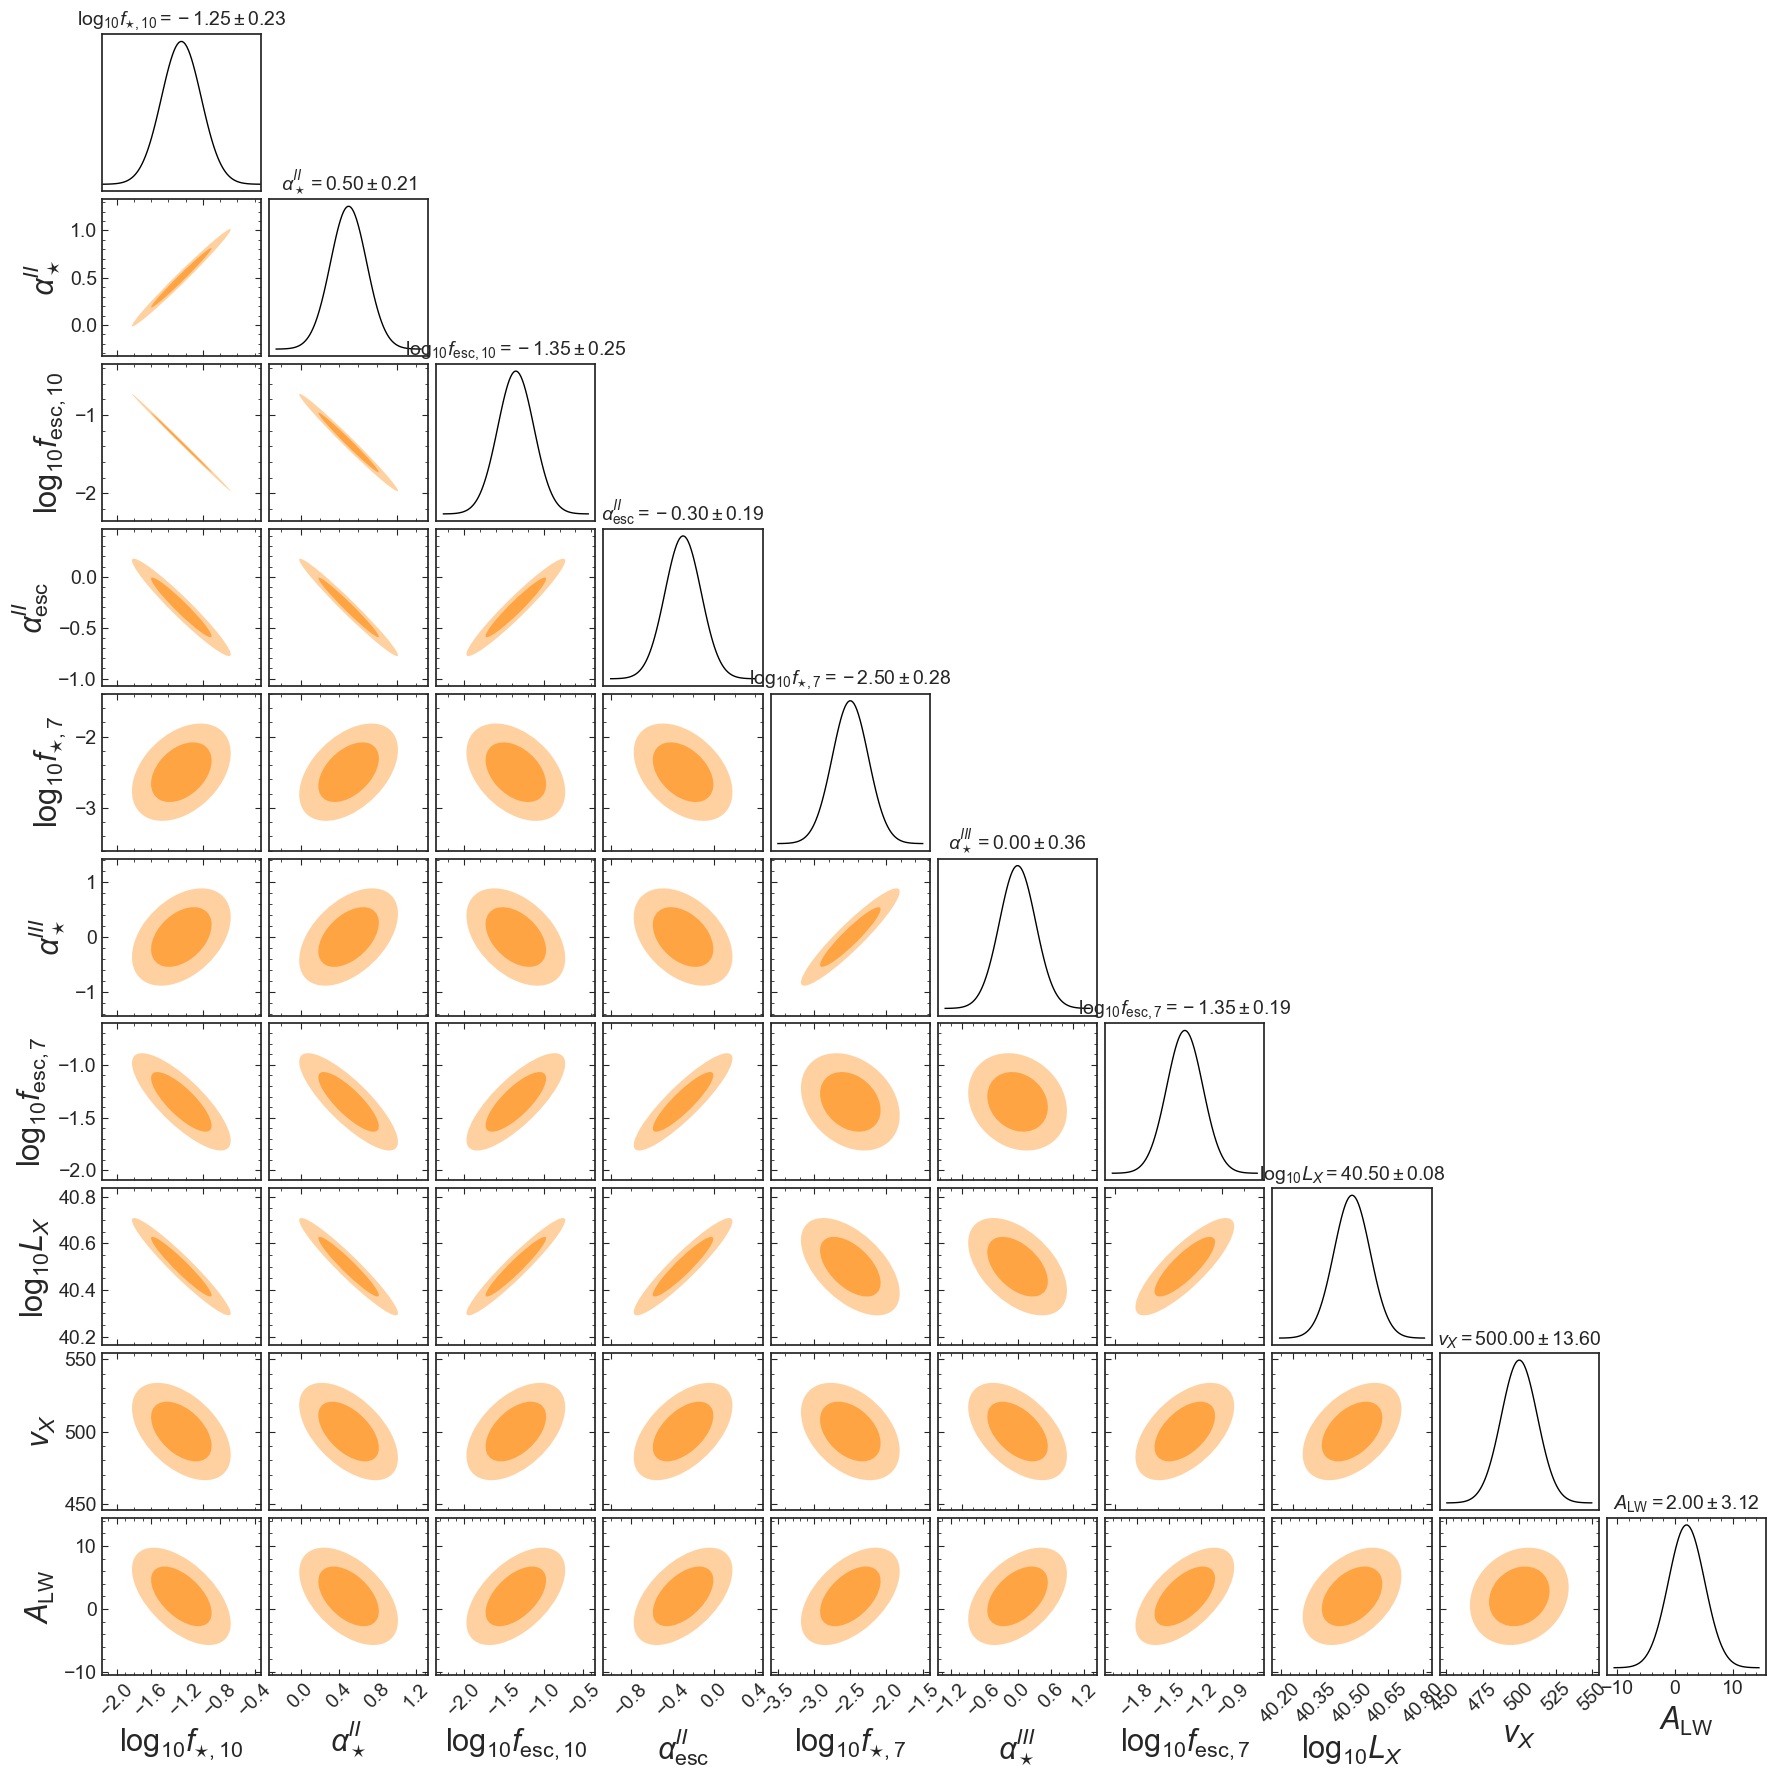

In [98]:
p21fish.plot_triangle(params=astro_params_vary_EoS, 
                      fiducial=fid_params,
                      labels=fid_labels,
                      cov=Finv_PS,
                      ellipse_color=col_mod,
                      title_fontsize=14,
                      xlabel_kwargs={'labelpad': 5, 'fontsize':22},
                      ylabel_kwargs={'labelpad': 5, 'fontsize':22},
                      fig_kwargs={'figsize':(18,18)});

plt.savefig(examples_dir+'corner_EoS_mini_fisher.png', bbox_inches='tight')

## Add a prior

E.g. [Park+2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484..933P/abstract) find $\sigma(\alpha_\star^{II}) \approx 0.07$.

To add a prior, we can add 1/$\sigma^2$ to the diagonal element for that parameter (e.g. [Coe 2009](arXiv:0906.4123))

ALPHA_STAR is at index=1


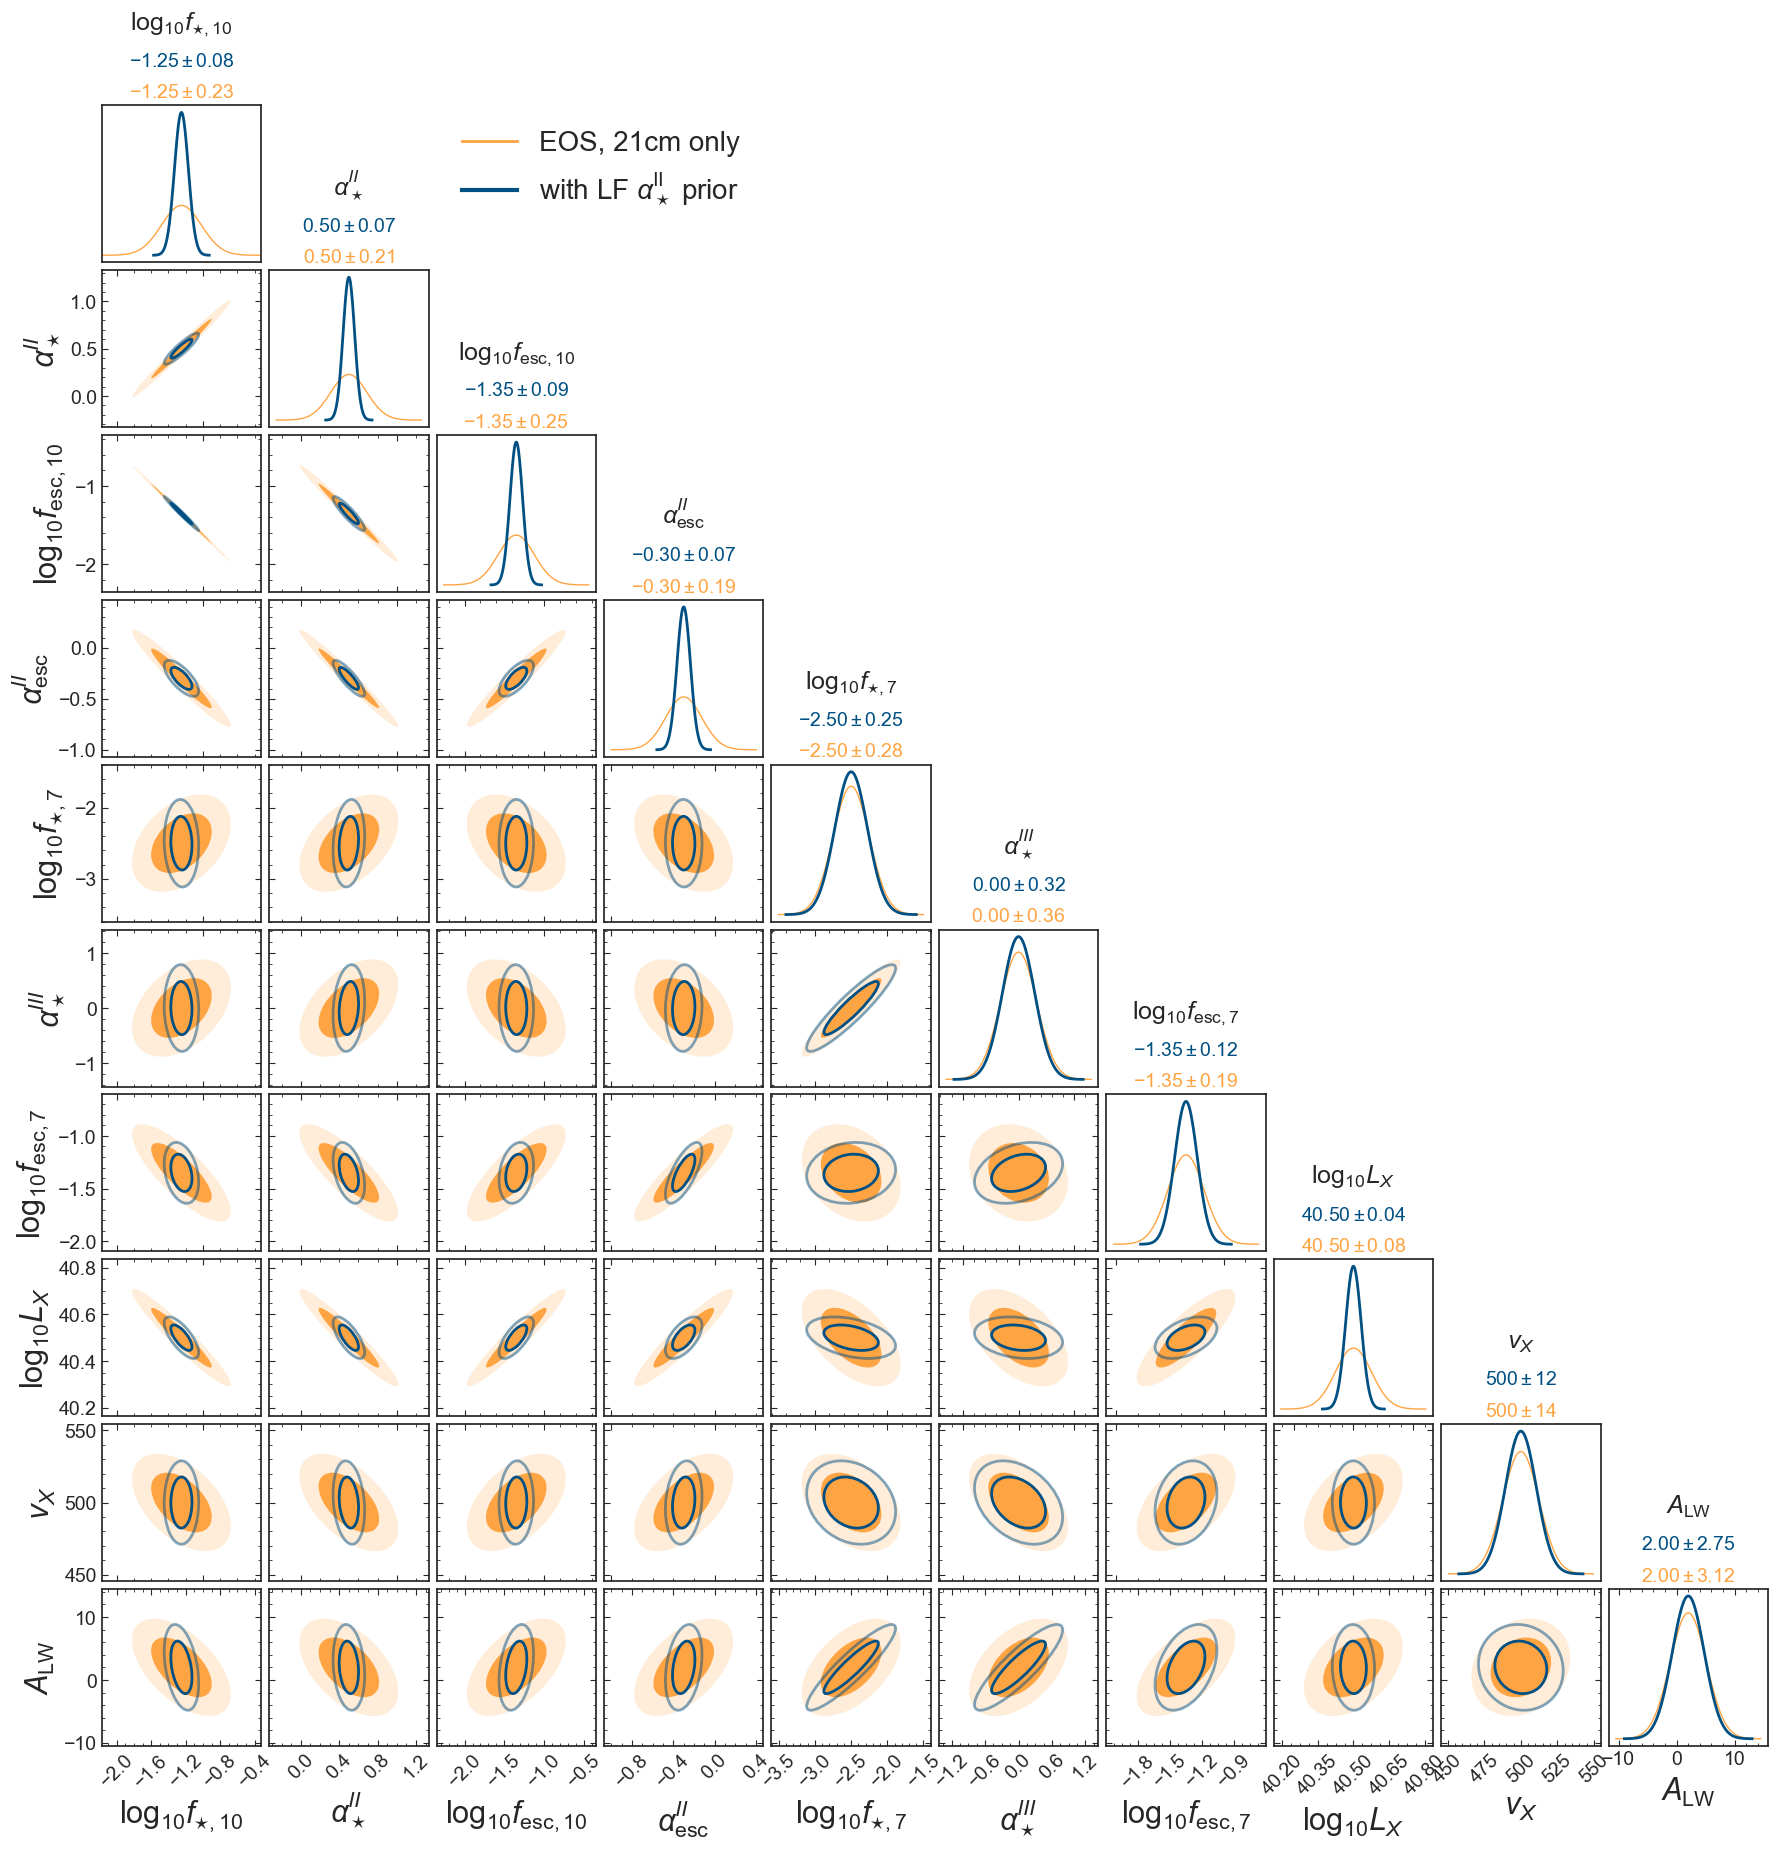

In [99]:
sigma_alpha_star_II = 0.07
idx_alpha_star = list(params_EoS).index("ALPHA_STAR")
print(f'ALPHA_STAR is at index={idx_alpha_star}')
Fij_matrix_PS_alpha_star_prior = Fij_matrix_PS.copy()
Fij_matrix_PS_alpha_star_prior[idx_alpha_star,idx_alpha_star] += 1/sigma_alpha_star_II**2.

Finv_alpha_star_prior = np.linalg.inv(Fij_matrix_PS_alpha_star_prior)

fig, ax = plt.subplots(len(fid_params), len(fid_params), figsize=(18,18))
cols = [col_mod, col_alpha]

for i, cov in enumerate([Finv_PS, Finv_alpha_star_prior]):

    col = cols[i]    
    if i == 0:
        resize_lims=True
        ellipse_color=col
        ellipse_kwargs=[{},{'alpha':0.2}]
        plot1D_kwargs={'c':col, 'lw':1}
    else:
        ls='solid'
        resize_lims=False
        ellipse_color='None'
        ellipse_kwargs=[{'edgecolor':col,'lw':2,'ls':ls},
                      {'edgecolor':col,'lw':2,'ls':ls,'alpha':0.5}]
        plot1D_kwargs={'c':col, 'lw':2, 'ls':ls}
        
    p21fish.plot_triangle(params=astro_params_vary_EoS, 
                          fiducial=fid_params,
                          labels=fid_labels,
                          cov=cov,
                          ellipse_color=ellipse_color,
                          ellipse_kwargs=ellipse_kwargs,
                          plot1D_kwargs=plot1D_kwargs,
                          resize_lims=resize_lims,
                          title_fontsize=14,
                          xlabel_kwargs={'labelpad': 5, 'fontsize':22},
                          ylabel_kwargs={'labelpad': 5, 'fontsize':22},
                          ax=ax, fig=fig);

    p21fish.title_double_ellipses(axes=ax, labels=fid_labels,
               med=fid_params, sigma=np.sqrt(cov.diagonal()),
               title_fontsize=18, title_pad=55,
               vspace=i/5,
               color=col
               )

no_prior = mlines.Line2D([], [], color=col_mod, lw=2, label='EOS, 21cm only')
w_prior  = mlines.Line2D([], [], color=col_alpha, lw=3, ls=ls, label=r'with LF $\alpha_\star^\mathrm{II}$ prior')

ax[0,2].legend(handles=[no_prior, w_prior], loc='upper left', fontsize=20)

plt.savefig(examples_dir+'corner_EoS_mini_fisher_ALPHA_STAR_prior.png', bbox_inches='tight')

## Pessimistic case

In [69]:
Fij_matrix_PS_pess, Finv_PS_pess = p21fish.make_fisher_matrix(params_EoS_pess, 
                                                             fisher_params=astro_params_vary_EoS, 
                                                             hpeak=0.0, obs='PS',
                                                             k_min=0.1, k_max=1, 
                                                             z_min=5.7, z_max=30., 
                                                             sigma_mod_frac=0.2,
                                                             add_sigma_poisson=True) 

PS shape: (20, 24)


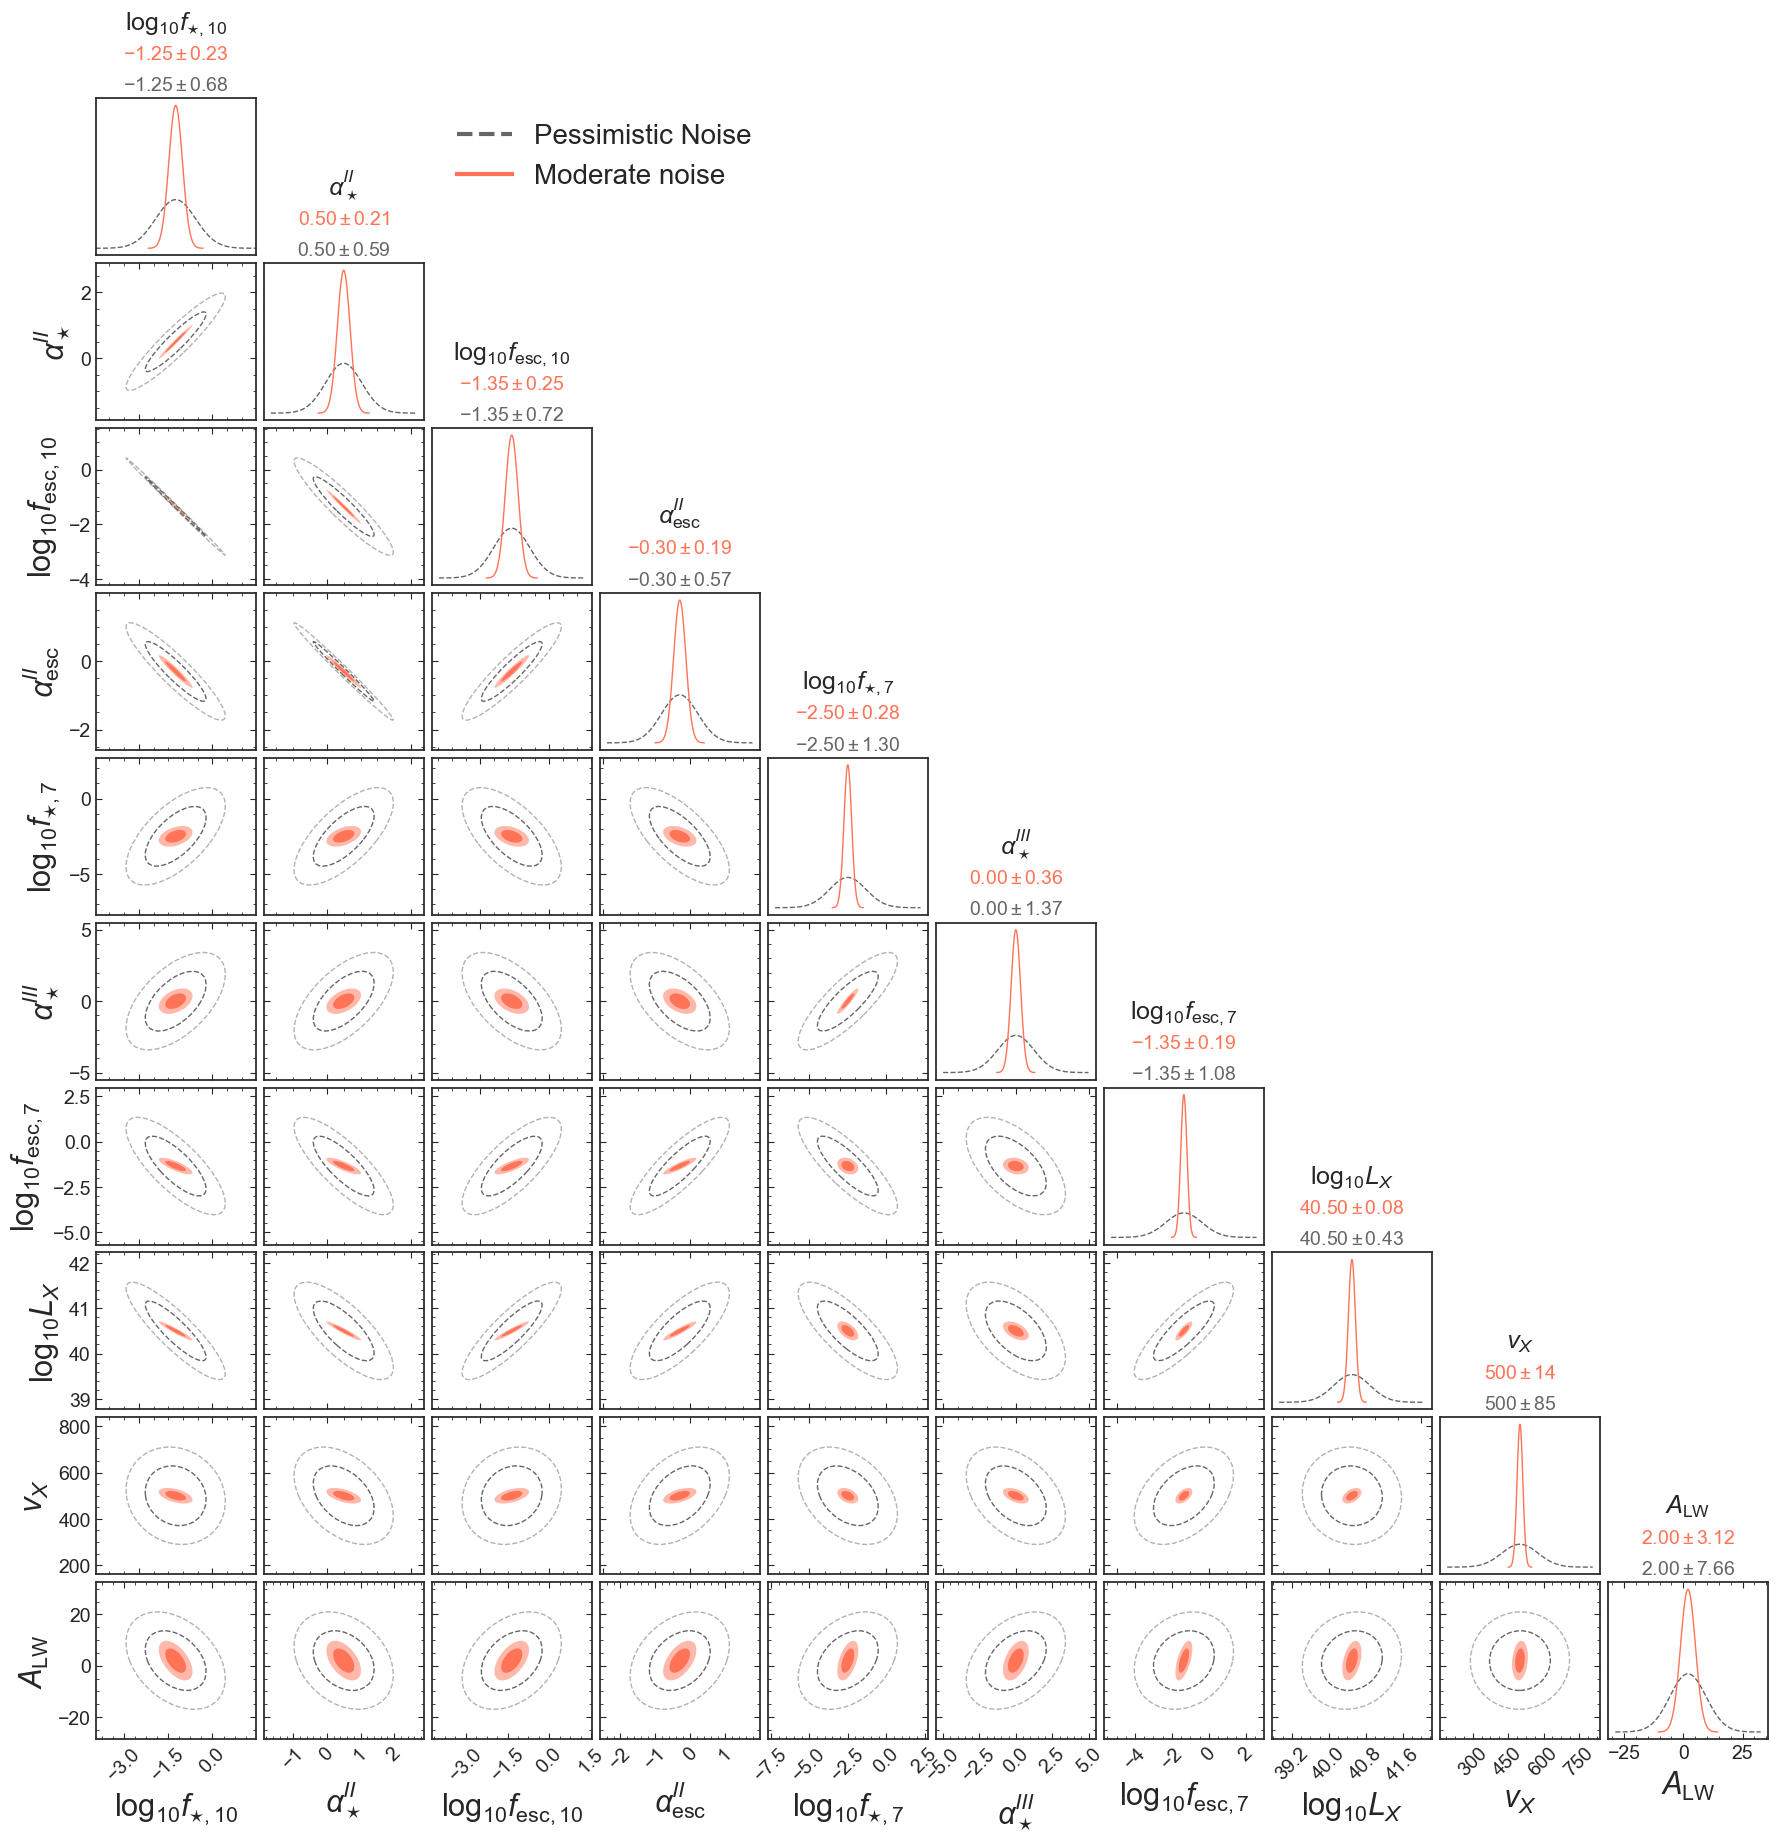

In [90]:
fig, ax = plt.subplots(len(fid_params), len(fid_params), figsize=(18,18))
cols = [col_pess, col_mod]

for i, cov in enumerate([Finv_PS_pess, Finv_PS]):

    col = cols[i]    
    if i == 0:
        resize_lims=True
        ellipse_color='None'
        ellipse_kwargs=[{'edgecolor':col,'lw':1,'ls':'dashed'},
                      {'edgecolor':col,'lw':1,'ls':'dashed','alpha':0.5}]
        plot1D_kwargs={'c':col, 'lw':1, 'ls':'dashed'}
    else:
        ls='solid'
        resize_lims=False
        ellipse_color=col
        ellipse_kwargs=[{},{'alpha':0.5}]
        plot1D_kwargs={'c':col, 'lw':1}
        
    p21fish.plot_triangle(params=astro_params_vary_EoS, 
                          fiducial=fid_params,
                          labels=fid_labels,
                          cov=cov,
                          ellipse_color=ellipse_color,
                          ellipse_kwargs=ellipse_kwargs,
                          plot1D_kwargs=plot1D_kwargs,
                          resize_lims=resize_lims,
                          title_fontsize=14,
                          xlabel_kwargs={'labelpad': 5, 'fontsize':22},
                          ylabel_kwargs={'labelpad': 5, 'fontsize':22},
                          ax=ax, fig=fig);

    p21fish.title_double_ellipses(axes=ax, labels=fid_labels,
               med=fid_params, sigma=np.sqrt(cov.diagonal()),
               title_fontsize=18, title_pad=50,
               vspace=i/5, color=col)

no_prior = mlines.Line2D([], [], color=col_pess, lw=3, ls='dashed', label='Pessimistic Noise')
w_prior  = mlines.Line2D([], [], color=col_mod, lw=3, label=r'Moderate noise')

ax[0,2].legend(handles=[no_prior, w_prior], loc='upper left', fontsize=20)

plt.savefig(examples_dir+'corner_EoS_mini_fisher_pessimistic.png', bbox_inches='tight')

### S/N

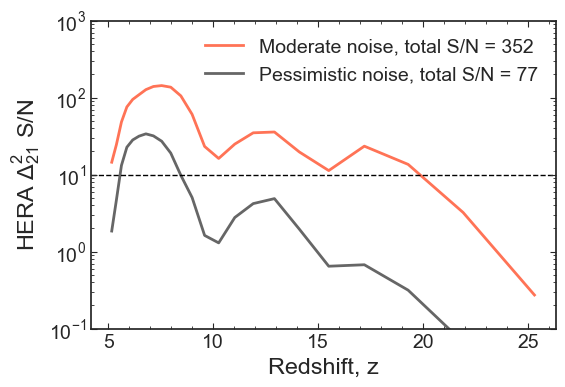

In [91]:
param_test = params_EoS['ALPHA_ESC']
param_test_pess = params_EoS_pess['ALPHA_ESC']

SNR = np.zeros((len(param_test.PS_z_HERA),2))
for i in range(len(param_test.PS_z_HERA)):
    PS     = np.interp(param_test.PS_err[i]['k']*0.7, 
                       param_test.PS['CDM']['ALPHA_ESC=-0.3'][i]['k'],
                       param_test.PS['CDM']['ALPHA_ESC=-0.3'][i]['delta'])
    
    PS_err = np.array([param_test.PS_err[i]['err_mod'],
                        param_test_pess.PS_err[i]['err_mod']])

    SNR[i] = np.sqrt(np.sum((PS/PS_err)**2., axis=1))


plt.figure(figsize=(6,4))
labels = ['Moderate','Pessimistic']
cols = [col_mod, col_pess]
for i, s in enumerate(SNR.T):
    SNR_total = np.sqrt(np.sum(s**2.)) # ~300
    plt.plot(param_test.PS_z_HERA, s, c=cols[i], label=f'{labels[i]} noise, total S/N = {SNR_total:.0f}')
plt.xlabel('Redshift, z')
plt.ylabel('HERA $\Delta_{21}^2$ S/N')
# plt.xticks(np.arange(4,26,2))

plt.axhline(10., lw=1, ls='dashed', c='k')
plt.legend()
# plt.grid(alpha=0.5, lw=0.5)
# plt.ylim(-1,50)
plt.ylim(1e-1,1e3)

plt.yscale('log')
plt.savefig(examples_dir+'SNR_EoS.pdf', bbox_inches='tight')

# Comparison to Park+19

Compare Fisher matrix with [Park+2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484..933P/abstract) fiducial to their MCMC (21cm power spectrum only)

In [46]:
output_dir_Park19 = data_dir+'Park19/'
PS_err_dir_Park19 = noise_dir+'21cmSense_noise_Park19/'
        
astro_params_vary_Park19, astro_params_fid_Park19 = p21fish.get_params_fid(
                                                    config_file=p21fish.base_path+'21cmFAST_config_files/Park19.config')

# Reorder to match Park+19
astro_params_vary_Park19 = ['F_STAR10', 'ALPHA_STAR',
                             'F_ESC10', 'ALPHA_ESC', 
                             'M_TURN', 't_STAR', 
                             'L_X', 'NU_X_THRESH']

In [47]:
# Load parameters
params_Park19 = {}
for param in astro_params_vary_Park19:
        
    params_Park19[param] = p21fish.Parameter(param=param, 
                                             output_dir=output_dir_Park19,
                                             HII_DIM=128, BOX_LEN=250,
                                             min_redshift=5.9,
                                             PS_err_dir=PS_err_dir_Park19,
                                             clobber=False, Park19='real',
                                             vb=False)

########### fisher set up for F_STAR10
########### fisher set up for ALPHA_STAR
########### fisher set up for F_ESC10
########### fisher set up for ALPHA_ESC
########### fisher set up for M_TURN
########### fisher set up for t_STAR
########### fisher set up for L_X
########### fisher set up for NU_X_THRESH


## Make Fisher matrix

In [48]:
Fij_matrix_PS_Park19, Finv_PS_Park19 = p21fish.make_fisher_matrix(params_Park19, 
                                                                fisher_params=astro_params_vary_Park19, 
                                                                hpeak=0.0, obs='PS',
                                                                k_min=0.1, k_max=1, 
                                                                z_min=5.7, z_max=30., 
                                                                sigma_mod_frac=0.2,
                                                                cosmo_key='CDM',
                                                                add_sigma_poisson=True) 

fid_params_Park19 = np.array([astro_params_fid_Park19[param] for param in params_Park19])
fid_labels_Park19 = np.array([p21fish.astro_params_labels[param] for param in params_Park19])

PS shape: (12, 23)


generating new axis


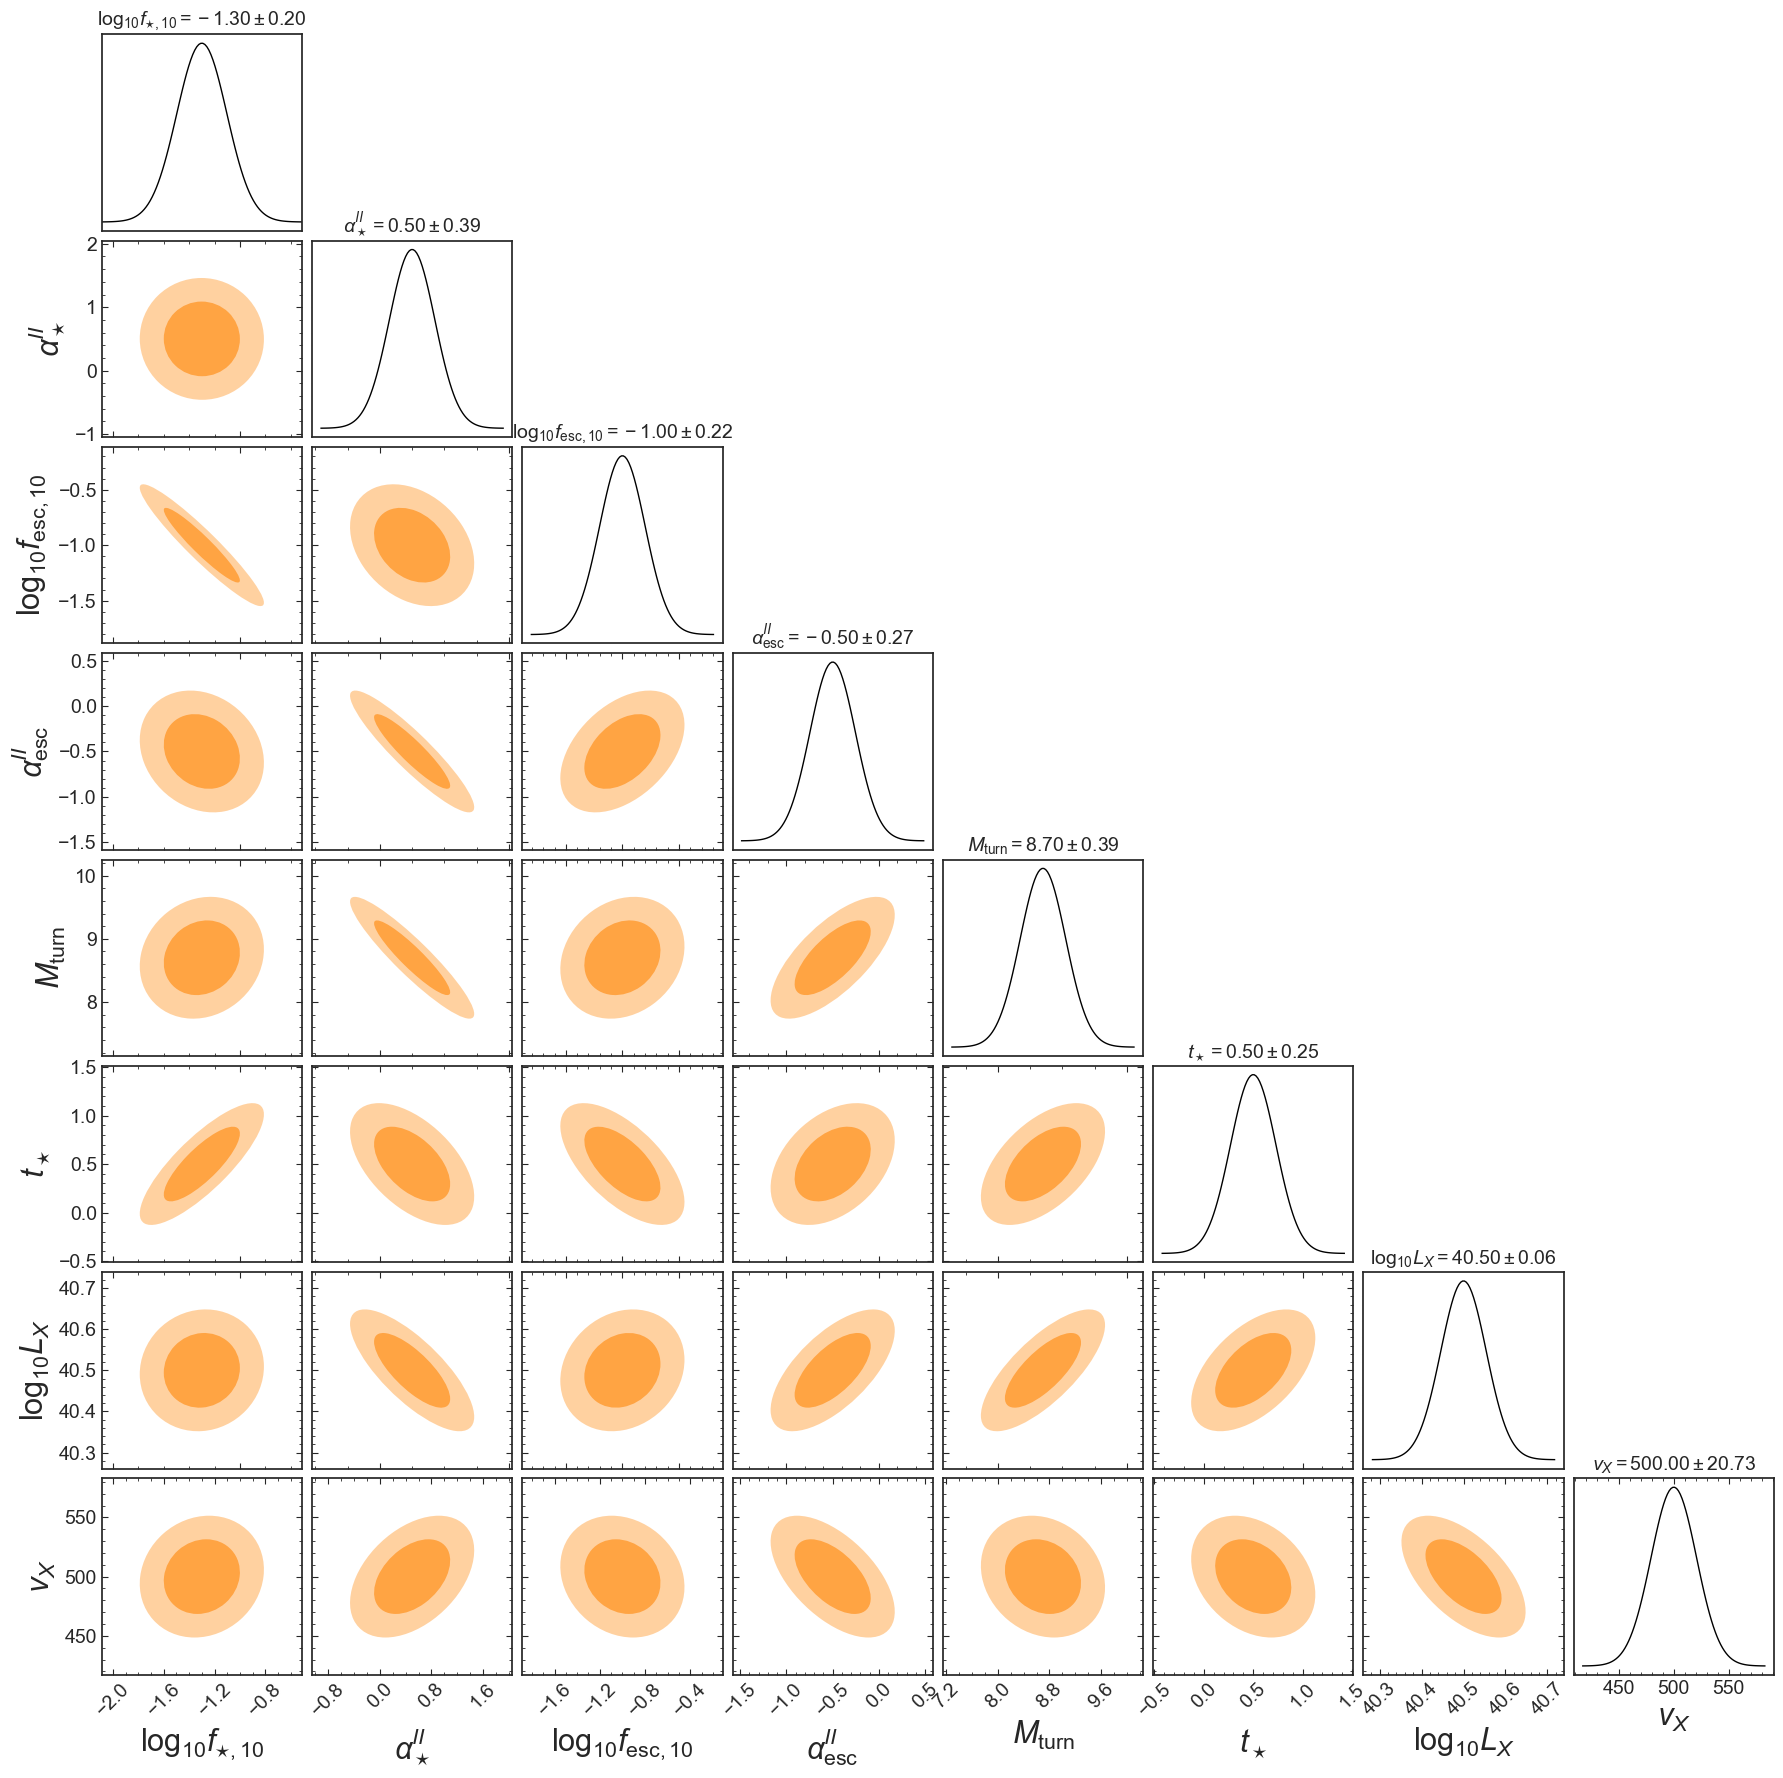

In [92]:
p21fish.plot_triangle(params=astro_params_vary_Park19, 
                      fiducial=fid_params_Park19,
                      labels=fid_labels_Park19,
                      cov=Finv_PS_Park19,
                      title_fontsize=14,
                      ellipse_color=col_P19,
                      xlabel_kwargs={'labelpad': 5, 'fontsize':22},
                      ylabel_kwargs={'labelpad': 5, 'fontsize':22},
                      fig_kwargs={'figsize':(18,18)});

plt.savefig(examples_dir+'corner_Park19_fisher.png', bbox_inches='tight')

## Load Park19 chains and compare

Load their 21cm-only chains and compare the contours

['F_STAR10' 'ALPHA_STAR' 'F_ESC10' 'ALPHA_ESC' 'M_TURN' 't_STAR' 'L_X'
 'E0']


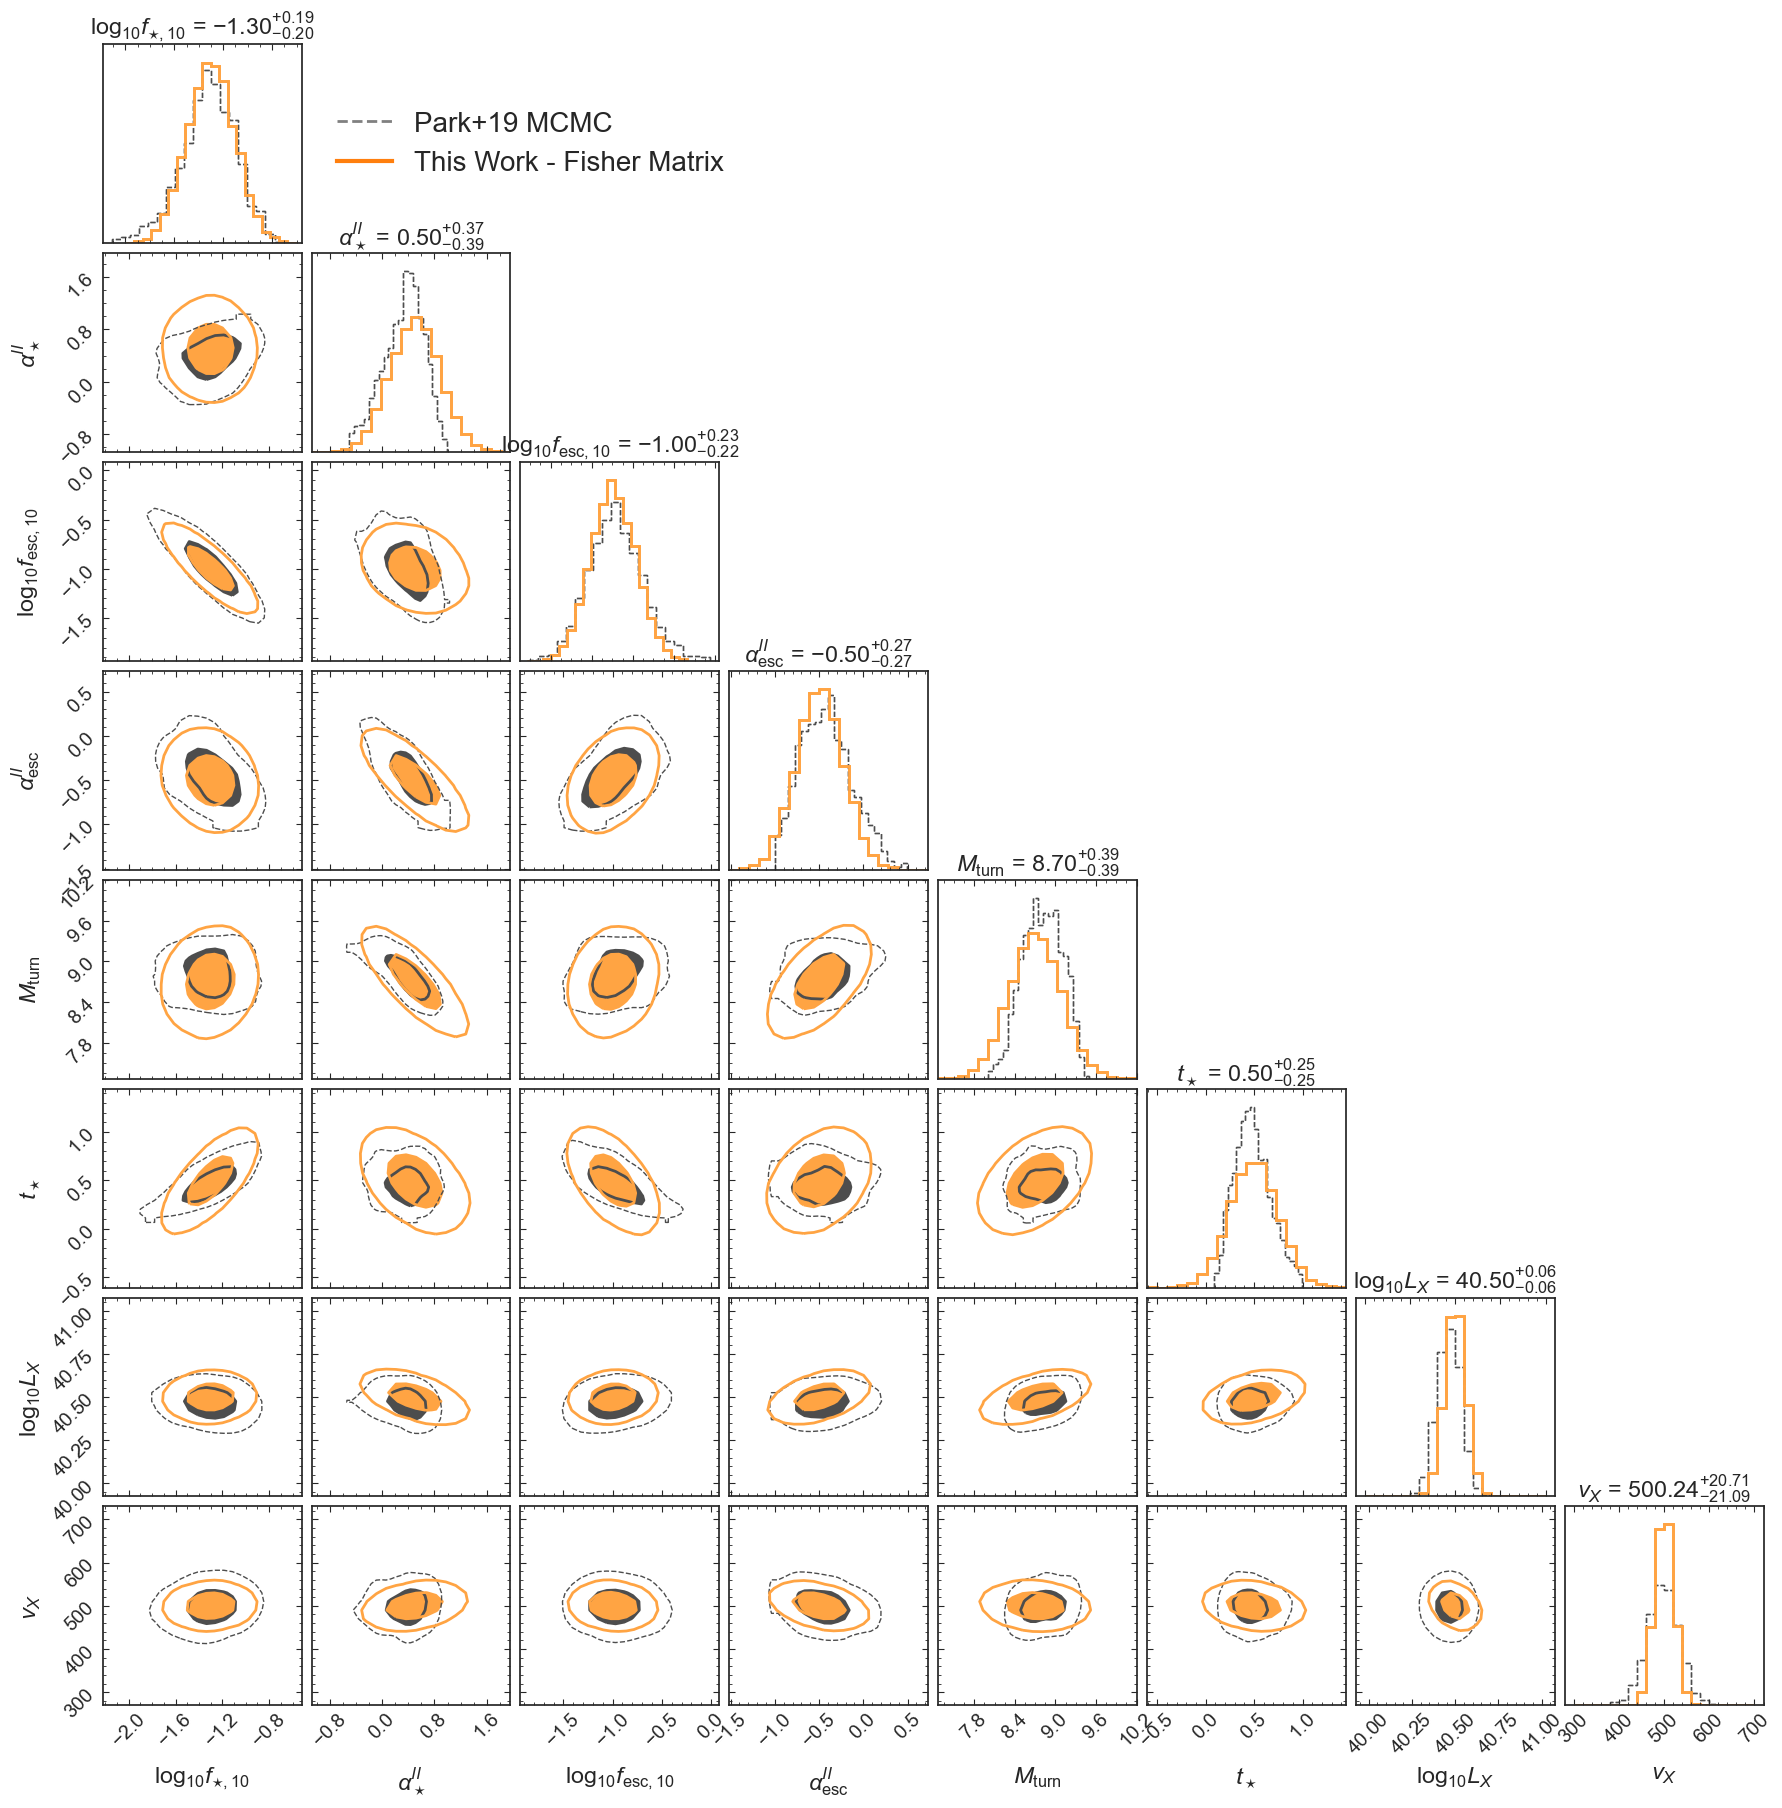

In [93]:
Park19_chains = np.load(f'{output_dir_Park19}Park19_chains.npz')
print(Park19_chains['params'])

# Make posteriors from the covariance matrix
mean = fid_params_Park19.copy()
cov  = Finv_PS_Park19.copy()
fisher_chain = np.random.multivariate_normal(mean, cov, size=10000)

# Corner plot
fig = plt.figure(figsize=(18,18))

colors = [col_mcmc,col_P19]
lws = [1,2]
# Plot 2 sigma confidence interval (https://corner.readthedocs.io/en/latest/pages/sigmas.html)
levels = 1.0 - np.exp(-0.5 * np.array([1,2,]) ** 2)
for ll, level in enumerate(levels):
    
    for cc, chain in enumerate([Park19_chains['chains'], fisher_chain]):
    
        if cc == 0:
            ls='dashed'
            lw=lws[cc]
            hist_kwargs = {'lw':lw,'ls':ls,'density':True}
            color=colors[cc]
        else:
            ls='solid'
            lw=lws[cc]
            hist_kwargs = {'lw':lw,'density':True}
            color=colors[cc]
            
        contourf_kwargs={}
        if ll == 0:
            contour_kwargs = {}
            no_fill_contours = False
            fill_contours = True
        else:
            contour_kwargs = {'linewidths':lw,'linestyles':ls}
            no_fill_contours  = True
            fill_contours = False
            
        corner.corner(chain, fig=fig,              
                    labels=fid_labels_Park19,
                    smooth=1,
                    color=color, use_math_text=True,
                    plot_datapoints=False, plot_density=False, 
                    no_fill_contours=no_fill_contours, fill_contours=fill_contours,
                    hist_kwargs=hist_kwargs,
                    contour_kwargs=contour_kwargs,contourf_kwargs=contourf_kwargs,
                    levels=[level],
                    range=[1,1,1,1,1,1,(40.,41.),(300,700)], # throws out a couple of outlier points in the chains [better for Lx]
                    show_titles=True,
                    );

lab_P19 = mlines.Line2D([], [], color='0.5', ls='dashed', lw=lws[0]+1, label='Park+19 MCMC')
lab_TW  = mlines.Line2D([], [], color='tab:orange', lw=lws[1]+1, label=r'This Work - Fisher Matrix')

fig.get_axes()[1].legend(handles=[lab_P19, lab_TW], loc='center left', fontsize=20)


plt.savefig(examples_dir+'corner_Park19_fisher_compare.png', bbox_inches='tight')

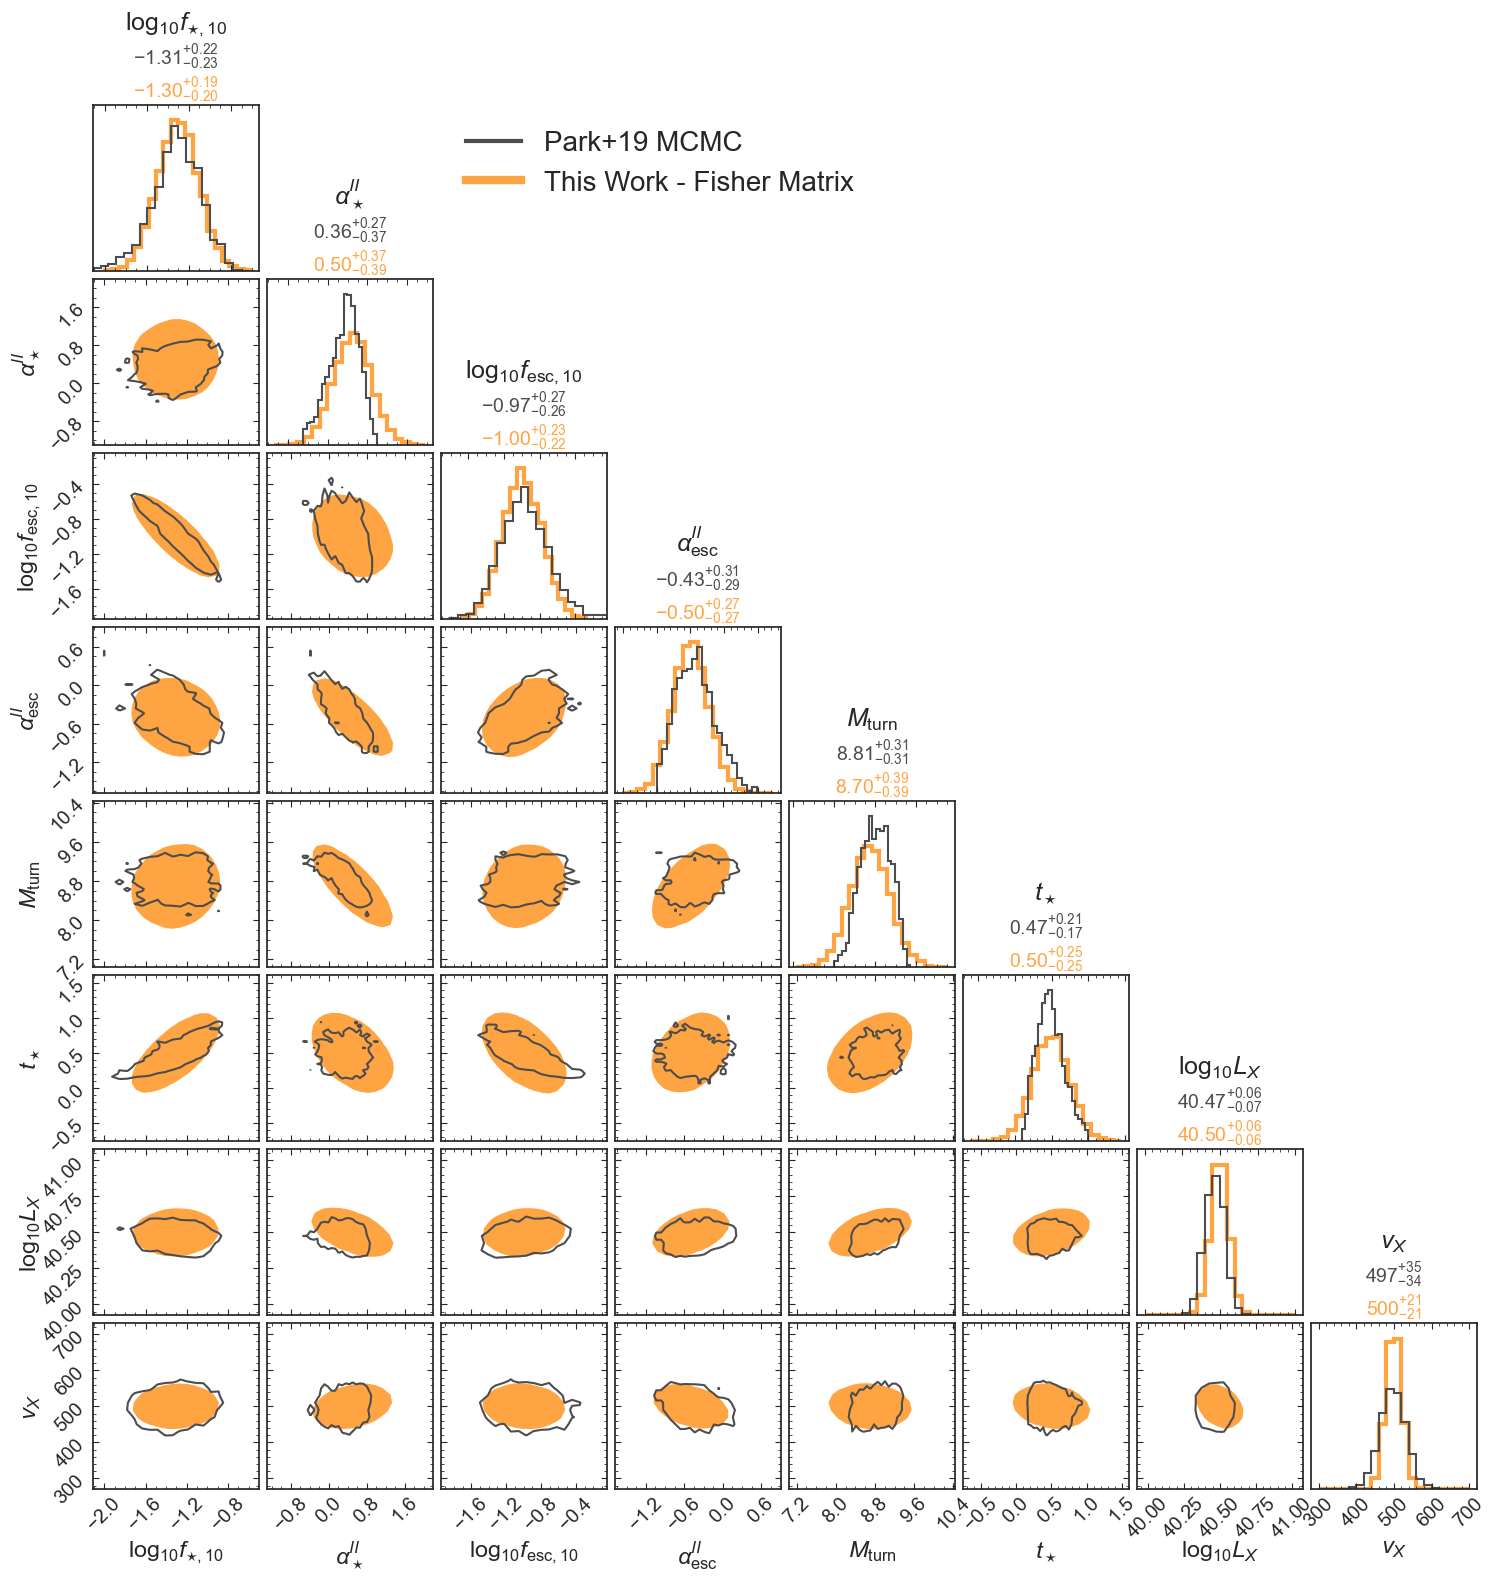

In [94]:
# Corner plot
fig = plt.figure(figsize=(15,15))

colors = [col_P19,col_mcmc]
lws = [3,1.5]
lss = ['solid','solid']

# Plot 2 sigma confidence interval (https://corner.readthedocs.io/en/latest/pages/sigmas.html)
levels = 1.0 - np.exp(-0.5 * np.array([1,]) ** 2)

for cc, chain in enumerate([fisher_chain, Park19_chains['chains']]):
    
    ls=lss[cc]
    lw=lws[cc]
    color=colors[cc]
    
    if cc == 1:
        hist_kwargs = {'lw':lw,'ls':ls,'density':True}
        contour_kwargs = {'linewidths':lw,'linestyles':ls}        
        fill_contours = False
        smooth=None
    else:  
        hist_kwargs = {'lw':lw,'density':True}
        contour_kwargs={}
        fill_contours = True
        smooth=1

    contourf_kwargs={}

    corner.corner(chain, fig=fig,              
                labels=fid_labels_Park19,
                smooth=smooth,
                color=color, use_math_text=True,
                plot_datapoints=False, plot_density=False, 
                no_fill_contours=no_fill_contours, fill_contours=fill_contours,
                hist_kwargs=hist_kwargs,
                contour_kwargs=contour_kwargs,contourf_kwargs=contourf_kwargs,
                levels=[level],
                range=[1,1,1,1,1,1,(40.,41.),(300,700)], # throws out a couple of outlier points in the chains [better for Lx]
                show_titles=True,
                );
    
    
    # Format the quantile display
    ax = np.reshape(fig.axes, (chain.shape[1],chain.shape[1]))

    p21fish.title_double_ellipses(axes=ax, labels=fid_labels_Park19,
                   chain=chain, 
                   med=None, sigma=None,
                   title_fontsize=18, title_pad=55,
                   vspace=cc/5,
                   color=color
                   )

lab_P19 = mlines.Line2D([], [], color=col_mcmc, ls=lss[1], lw=2*lws[1], label='Park+19 MCMC')
lab_TW  = mlines.Line2D([], [], color=col_P19,  ls=lss[0], lw=2*lws[0], label=r'This Work - Fisher Matrix')

fig.get_axes()[2].legend(handles=[lab_P19, lab_TW], loc='upper left', fontsize=20)

plt.savefig(examples_dir+'corner_Park19_fisher_compare_1sigma.png', bbox_inches='tight')

# Adding a new parameter

If you want to add your own new parameter, you should:

1. Create lightcones varying that parameter.
    1. Create a config file for the parameters you want to change (take one of the examples in `../21cmFAST_config_files/` and replace the `astro_params_vary` list with your list of new parameters.
    2. Note that the fiducial parameter value for your new parameter will be the 21cmFAST default unless the fiducial value is specified in the config file. If you want a non-default fiducial parameter value you will need to create a new set of lightcones with your parameter's fiducial included in `astro_params`.
    3. Create the lightcones using `scripts/make_lightcones_for_fisher.py`
2. Load your new parameter by adding it to the dictionary [as above](#EOS21)

See more details on running `scripts/make_lightcones_for_fisher.py` in the [docs](https://21cmfish.readthedocs.io/en/latest/usage.html) 